In [1]:
import torch
import matplotlib.pyplot as plt
from torch import distributions
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
from tqdm.auto import tqdm
import matplotlib as mpl
mpl.rcParams['font.size'] = 14

torch.manual_seed(42)
np.random.seed(42)
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

from network import ClassifierNN,load_model_info
from density_utils_modified import draw_density_ratio, refine_sample, refine_sample2, draw_density_ratio2

from utils import load_item, show_grasp
from dataset import ToyGraspDataset

In [2]:
dataset = ToyGraspDataset(root='data', size=1200)
data = dataset.data
pos_masks = data[:,2] == 1
neg_masks = ~pos_masks
handle_masks = data[:,3] == 1

In [3]:
# load pos vs neg classifier
f = ClassifierNN([2, 64, 64, 1])
f, info = load_model_info('pos_vs_neg', f)
f = f.to(device)

0.0 0.99961215


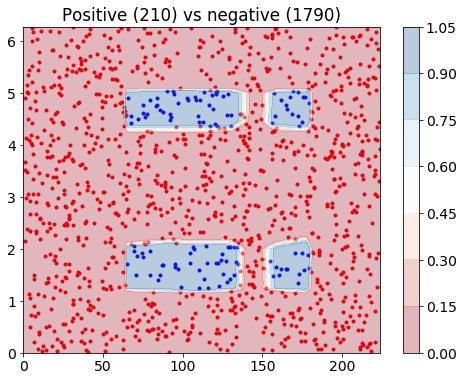

In [4]:
fig, ax = plt.subplots(nrows=1, figsize=(8,6))
ax.scatter(data[pos_masks][:,0], data[pos_masks][:,1], marker='.', alpha=1.0, color='b')
ax.scatter(data[neg_masks][:,0], data[neg_masks][:,1], marker='.', alpha=1.0, color='r')
Z, CS = draw_density_ratio(ax=ax,
                   model=f,
                   p_type='p_y_given_x',
                   device=device,
                   x_lim=[0, 224],
                   y_lim=[0, 2*np.pi],
                   cmap='RdBu',
                   step_size=0.05)

ax.set_title(f'Positive ({int(info["pos_samples_size"])}) vs negative ({int(info["neg_samples_size"])})')
fig.colorbar(CS, ax=ax)
ax.set_xlim([0, 224])
ax.set_ylim([0, 2*np.pi])

plt.show()

-7.854413 568.33105


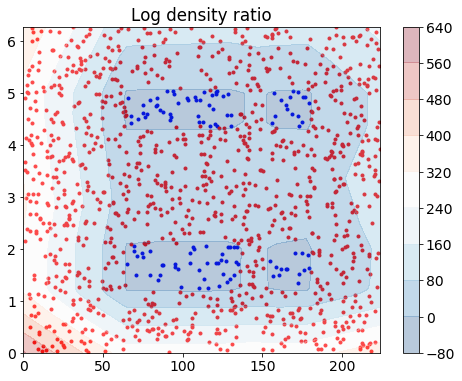

In [5]:
fig, ax = plt.subplots(nrows=1, figsize=(8,6))
ax.scatter(data[pos_masks][:,0], data[pos_masks][:,1], marker='.', alpha=1.0, color='b')
ax.scatter(data[neg_masks][:,0], data[neg_masks][:,1], marker='.', alpha=1.0, color='r')
Z, CS = draw_density_ratio(ax=ax,
                   model=f,
                   p_type='log_density_ratio',
                   device=device,
                   x_lim=[0, 224],
                   y_lim=[0, 2*np.pi],
                   cmap='RdBu_r',
                   step_size=0.05)

ax.set_title(f'Log density ratio')
fig.colorbar(CS, ax=ax)
ax.set_xlim([0, 224])
ax.set_ylim([0, 2*np.pi])

plt.show()

In [6]:
# refine samples
my_sample = torch.FloatTensor([[25, 0.3],
                               [210, 3]])#[160, 3]
my_sample[:,0] /= 224
my_sample[:,1] /= (2*3.14)

In [7]:
#steps_refinement = 100
all_x1, all_v1 = refine_sample(my_sample.to(device), f, success_threshold=0.9999,
                               eta=0.0001, noise_factor=0.001,
                              Nq = info['pos_samples_size'], Np = info['neg_samples_size'])

All samples converged within 282 iterations.


-0.9214675 66.67571


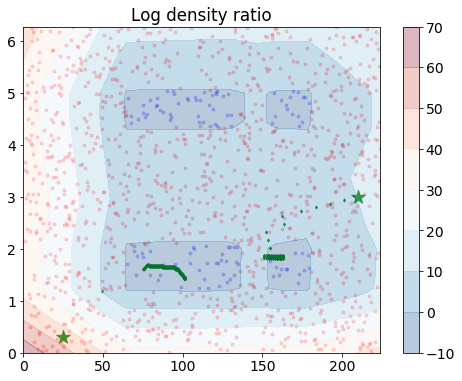

In [8]:
fig, ax = plt.subplots(nrows=1, figsize=(8,6))
ax.scatter(data[pos_masks][:,0], data[pos_masks][:,1], marker='.', alpha=0.2, color='b')
ax.scatter(data[neg_masks][:,0], data[neg_masks][:,1], marker='.', alpha=0.2, color='r')

plt.scatter(my_sample[:, 0]*224, my_sample[:,1]*(2*3.14), marker='*', color='g', s=200)
for i in range(1, len(all_x1), 1):
    plt.scatter(all_x1[i][:, 0]*224, all_x1[i][:,1]*(2*3.14), marker='d', color='g', s=4)

Z, CS = draw_density_ratio(ax=ax,
                   model=f,
                   p_type='log_density_ratio',
                   device=device,
                   x_lim=[0, 224],
                   y_lim=[0, 2*np.pi],
                   cmap='RdBu_r',
                   step_size=0.05,
                      Np=info['neg_samples_size'], Nq=info['pos_samples_size'])

ax.set_title(f'Log density ratio')
fig.colorbar(CS, ax=ax)
ax.set_xlim([0, 224])
ax.set_ylim([0, 2*np.pi])

plt.show()

In [9]:
all_x1, all_v1 = refine_sample(my_sample.to(device), f, success_threshold=0.6,
                               eta=0.000001, noise_factor=0.001,
                              Nq = info['pos_samples_size'], Np = info['neg_samples_size'])

All samples converged within 718 iterations.


-0.9214675 66.67571


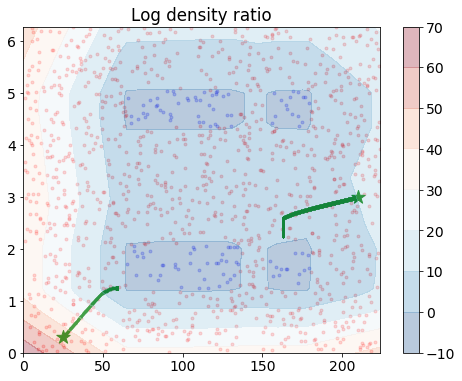

In [10]:
fig, ax = plt.subplots(nrows=1, figsize=(8,6))
ax.scatter(data[pos_masks][:,0], data[pos_masks][:,1], marker='.', alpha=0.2, color='b')
ax.scatter(data[neg_masks][:,0], data[neg_masks][:,1], marker='.', alpha=0.2, color='r')

plt.scatter(my_sample[:, 0]*224, my_sample[:,1]*(2*3.14), marker='*', color='g', s=200)
for i in range(1, len(all_x1), 1):
    plt.scatter(all_x1[i][:, 0]*224, all_x1[i][:,1]*(2*3.14), marker='d', color='g', s=4)

Z, CS = draw_density_ratio(ax=ax,
                   model=f,
                   p_type='log_density_ratio',
                   device=device,
                   x_lim=[0, 224],
                   y_lim=[0, 2*np.pi],
                   cmap='RdBu_r',
                   step_size=0.05,
                      Np=info['neg_samples_size'], Nq=info['pos_samples_size'])

ax.set_title(f'Log density ratio')
fig.colorbar(CS, ax=ax)
ax.set_xlim([0, 224])
ax.set_ylim([0, 2*np.pi])

plt.show()

# Handle

In [11]:
# load pos vs neg classifier
f2 = ClassifierNN([2, 32, 1])
f2, info2 = load_model_info('handle', f2)
f2 = f2.to(device)

4.631624e-26 0.9999937


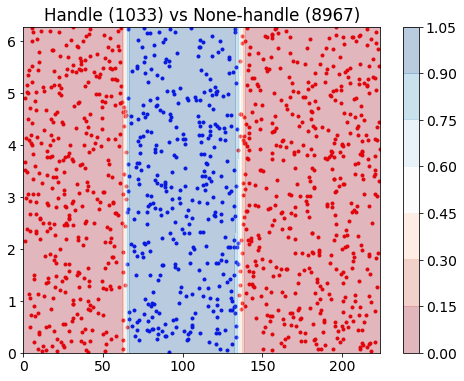

In [12]:
fig, ax = plt.subplots(nrows=1, figsize=(8,6))
ax.scatter(data[handle_masks][:,0], data[handle_masks][:,1], marker='.', alpha=1.0, color='b')
ax.scatter(data[~handle_masks][:,0], data[~handle_masks][:,1], marker='.', alpha=1.0, color='r')
Z, CS = draw_density_ratio(ax=ax,
                   model=f2,
                   p_type='p_y_given_x',
                   device=device,
                   x_lim=[0, 224],
                   y_lim=[0, 2*np.pi],
                   cmap='RdBu',
                   step_size=0.05)




ax.set_title(f'Handle ({int(info2["pos_samples_size"])}) vs None-handle ({int(info2["neg_samples_size"])})')
fig.colorbar(CS, ax=ax)
ax.set_xlim([0, 224])
ax.set_ylim([0, 2*np.pi])

plt.show()

In [13]:
# steps_refinement = 100
success_threshold = 0.8
all_x1, all_v1 = refine_sample(my_sample.to(device), f2, success_threshold=0.8,
                               eta=0.0001, noise_factor=0.0000,
                              Nq = info2['pos_samples_size'], Np = info2['neg_samples_size'])

All samples converged within 26 iterations.


-1.3796068 6.7201223


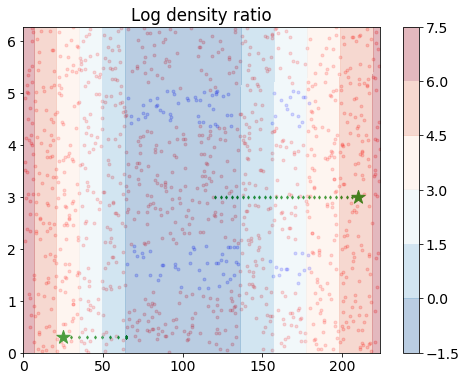

In [14]:
fig, ax = plt.subplots(nrows=1, figsize=(8,6))
ax.scatter(data[pos_masks][:,0], data[pos_masks][:,1], marker='.', alpha=0.2, color='b')
ax.scatter(data[neg_masks][:,0], data[neg_masks][:,1], marker='.', alpha=0.2, color='r')

plt.scatter(my_sample[:, 0]*224, my_sample[:,1]*(2*3.14), marker='*', color='g', s=200)
for i in range(1, len(all_x1), 1):
    plt.scatter(all_x1[i][:, 0]*224, all_x1[i][:,1]*(2*3.14), marker='d', color='g', s=4)


Z, CS = draw_density_ratio(ax=ax,
                   model=f2,
                   p_type='log_density_ratio',
                   device=device,
                   x_lim=[0, 224],
                   y_lim=[0, 2*np.pi],
                   cmap='RdBu_r',
                   step_size=0.05,
                   Np=info2['neg_samples_size'], Nq=info2['pos_samples_size'])

ax.set_title(f'Log density ratio')
fig.colorbar(CS, ax=ax)
ax.set_xlim([0, 224])
ax.set_ylim([0, 2*np.pi])

plt.show()

### Multiple classifiers

In [15]:
#steps_refinement = 100
all_x8, all_v8 = refine_sample2(my_sample.to(device), f, f2,
                                success_threshold=0.6,
                                eta=0.00004,
                                noise_factor=0.000,
                                Np1=info['neg_samples_size'],
                                Nq1=info['pos_samples_size'],
                                Np2=info2['neg_samples_size'],
                                Nq2=info2['pos_samples_size']
                                )
all_x8 = torch.cat(all_x8).numpy()

All samples converged within 79 iterations.


In [16]:
# Np1=info['neg_samples_size'],
#                                 Nq1=info['pos_samples_size'],
#                                 Np2=info2['neg_samples_size'],
#                                 Nq2=info2['pos_samples_size']

-14.032875 131680.19


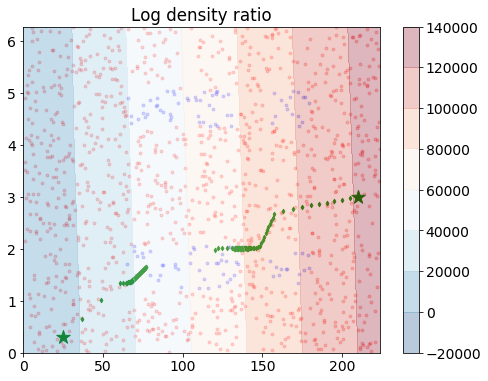

In [17]:
fig, ax = plt.subplots(nrows=1, figsize=(8,6))
ax.scatter(data[pos_masks][:,0], data[pos_masks][:,1], marker='.', alpha=0.2, color='b')
ax.scatter(data[neg_masks][:,0], data[neg_masks][:,1], marker='.', alpha=0.2, color='r')

plt.scatter(my_sample[:, 0]*224, my_sample[:,1]*(2*3.14), marker='*', color='g', s=200)
# for i in range(1, steps_refinement, 1):
plt.scatter(all_x8[:,0]*224, all_x8[:,1]*(2*3.14), marker='d', color='g', s=10)

Z, CS = draw_density_ratio2(ax=ax,
                   model1=f,
                   model2=f2,
                   device=device,
                   x_lim=[0, 224],
                   y_lim=[0, 2*np.pi],
                   cmap='RdBu_r',
                   step_size=0.05,
                   Np1=info['neg_samples_size'],
                   Nq1=info['pos_samples_size'],
                   Np2=info2['neg_samples_size'],
                   Nq2=info2['pos_samples_size'])

ax.set_title(f'Log density ratio')
fig.colorbar(CS, ax=ax)
ax.set_xlim([0, 224])
ax.set_ylim([0, 2*np.pi])

plt.show()

In [19]:
#steps_refinement = 100
all_x8, all_v8 = refine_sample2(my_sample.to(device), f, f2,
                                success_threshold=0.95,
                                eta=0.00004,
                                noise_factor=0.000,
                                Np1=info['neg_samples_size'],
                                Nq1=info['pos_samples_size'],
                                Np2=info2['neg_samples_size'],
                                Nq2=info2['pos_samples_size']
                                )
all_x8 = torch.cat(all_x8).numpy()

All samples converged within 81 iterations.


-14.032875 131680.19


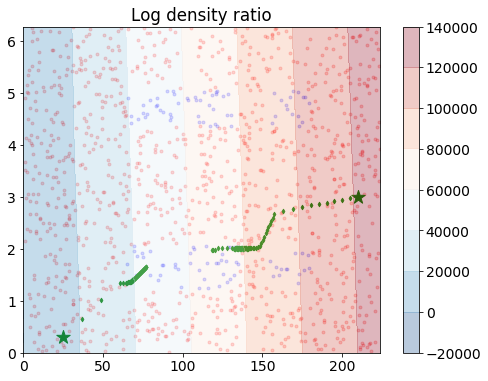

In [20]:
fig, ax = plt.subplots(nrows=1, figsize=(8,6))
ax.scatter(data[pos_masks][:,0], data[pos_masks][:,1], marker='.', alpha=0.2, color='b')
ax.scatter(data[neg_masks][:,0], data[neg_masks][:,1], marker='.', alpha=0.2, color='r')

plt.scatter(my_sample[:, 0]*224, my_sample[:,1]*(2*3.14), marker='*', color='g', s=200)
# for i in range(1, steps_refinement, 1):
plt.scatter(all_x8[:,0]*224, all_x8[:,1]*(2*3.14), marker='d', color='g', s=10)

Z, CS = draw_density_ratio2(ax=ax,
                   model1=f,
                   model2=f2,
                   device=device,
                   x_lim=[0, 224],
                   y_lim=[0, 2*np.pi],
                   cmap='RdBu_r',
                   step_size=0.05,
                   Np1=info['neg_samples_size'],
                   Nq1=info['pos_samples_size'],
                   Np2=info2['neg_samples_size'],
                   Nq2=info2['pos_samples_size'])

ax.set_title(f'Log density ratio')
fig.colorbar(CS, ax=ax)
ax.set_xlim([0, 224])
ax.set_ylim([0, 2*np.pi])

plt.show()

In [18]:
sdgdg

NameError: name 'sdgdg' is not defined

In [ ]:
item = load_item('fork')

In [ ]:
# from matplotlib.patches import ArrowStyle
from matplotlib import animation
# arrow_style = ArrowStyle("Simple", head_length=.6, head_width=1.0, tail_width=.1)
from matplotlib.patches import Arrow

In [ ]:
%matplotlib notebook

In [ ]:
sample_stream = all_x8[1::2]

In [ ]:
# def animate_grasp(sample_stream, fname):
fname = 'bad_to_pos_handle'
fig, ax = plt.subplots(nrows=1, figsize=(4, 4))
x, angle = sample_stream[0]
x *= 224
angle *= 2*3.14
x2_coef = np.sin(angle)
x1_coef = np.cos(angle)
x1 = x + x1_coef*50#+50#*50
x2 = 224/2 + x2_coef*50# +50#*50

im = ax.imshow(item, cmap='Greys')
arr1 = Arrow(x1,x2,x+x1_coef*20-x1, 224/2+x2_coef*20-x2, width=15)
arr1 = ax.add_patch(arr1)

x1 = x - x1_coef*50
x2 = 224/2 - x2_coef*50
arrow = Arrow(x1,x2, x-x1_coef*20-x1, 224/2-x2_coef*20-x2, width=15)
arr2 = ax.add_patch(arrow)

origin = ax.scatter(x, 224/2, s=40, color='g')


def init():
    global im, arr1, arr2, origin

    x, angle = sample_stream[0]
    x *= 224
    angle *= 2*3.14
    x2_coef = np.sin(angle)
    x1_coef = np.cos(angle)
    x1 = x + x1_coef*50#+50#*50
    x2 = 224/2 + x2_coef*50# +50#*50

    arr1.remove()
    arr1 = Arrow(x1,x2,x+x1_coef*20-x1, 224/2+x2_coef*20-x2, width=15)
    ax.add_patch(arr1)

    arr2.remove()
    x1 = x - x1_coef*50
    x2 = 224/2 - x2_coef*50
    arrow = Arrow(x1,x2, x-x1_coef*20-x1, 224/2-x2_coef*20-x2, width=15)
    arr2 = ax.add_patch(arrow)


    origin.set_offsets((x, 224/2))
    return im, arr1, arr2, origin

# let us make animation
def animate(i):
    global im, arr1, arr2, origin
    if i <=30:
        init()
        return
    else:
        i = i - 30
    x, angle = sample_stream[i]
    x *= 224
    angle *= 2*3.14
    x2_coef = np.sin(angle)
    x1_coef = np.cos(angle)
    x1 = x + x1_coef*50#+50#*50
    x2 = 224/2 + x2_coef*50# +50#*50

    arr1.remove()
    arrow = Arrow(x1,x2,x+x1_coef*20-x1, 224/2+x2_coef*20-x2, width=15)
    arr1 = ax.add_patch(arrow)

    arr2.remove()
    x1 = x - x1_coef*50
    x2 = 224/2 - x2_coef*50
    arrow = Arrow(x1,x2, x-x1_coef*20-x1, 224/2-x2_coef*20-x2, width=15)
    arr2 = ax.add_patch(arrow)


    origin.set_offsets((x, 224/2))
    return im, arr1, arr2, origin

Writer = animation.writers['ffmpeg']
writer = Writer(fps=30, metadata=dict(artist='Me'), bitrate=20000)

# anim = animation.FuncAnimation(fig, animate, init_func=init, interval=1500, blit=True, frames=30+sample_stream.shape[0])
# anim.save(f'{fname}.mp4', writer=writer)
plt.show()

In [ ]:
sample_stream = all_x8[::2]

In [ ]:
# def animate_grasp(sample_stream, fname):
fname = 'neg_to_pos'
fig, ax = plt.subplots(nrows=1, figsize=(4, 4))
x, angle = sample_stream[0]
x *= 224
angle *= 2*3.14
x2_coef = np.sin(angle)
x1_coef = np.cos(angle)
x1 = x + x1_coef*50#+50#*50
x2 = 224/2 + x2_coef*50# +50#*50

im = ax.imshow(item, cmap='Greys')
arr1 = Arrow(x1,x2,x+x1_coef*20-x1, 224/2+x2_coef*20-x2, width=15)
arr1 = ax.add_patch(arr1)

x1 = x - x1_coef*50
x2 = 224/2 - x2_coef*50
arrow = Arrow(x1,x2, x-x1_coef*20-x1, 224/2-x2_coef*20-x2, width=15)
arr2 = ax.add_patch(arrow)

origin = ax.scatter(x, 224/2, s=40, color='g')


def init():
    global im, arr1, arr2, origin

    x, angle = sample_stream[0]
    x *= 224
    angle *= 2*3.14
    x2_coef = np.sin(angle)
    x1_coef = np.cos(angle)
    x1 = x + x1_coef*50#+50#*50
    x2 = 224/2 + x2_coef*50# +50#*50

    arr1.remove()
    arr1 = Arrow(x1,x2,x+x1_coef*20-x1, 224/2+x2_coef*20-x2, width=15)
    ax.add_patch(arr1)

    arr2.remove()
    x1 = x - x1_coef*50
    x2 = 224/2 - x2_coef*50
    arrow = Arrow(x1,x2, x-x1_coef*20-x1, 224/2-x2_coef*20-x2, width=15)
    arr2 = ax.add_patch(arrow)


    origin.set_offsets((x, 224/2))
    return im, arr1, arr2, origin

# let us make animation
def animate(i):
    global im, arr1, arr2, origin
    if i <=30:
        init()
        return
    else:
        i = i - 30
    x, angle = sample_stream[i]
    x *= 224
    angle *= 2*3.14
    x2_coef = np.sin(angle)
    x1_coef = np.cos(angle)
    x1 = x + x1_coef*50#+50#*50
    x2 = 224/2 + x2_coef*50# +50#*50

    arr1.remove()
    arrow = Arrow(x1,x2,x+x1_coef*20-x1, 224/2+x2_coef*20-x2, width=15)
    arr1 = ax.add_patch(arrow)

    arr2.remove()
    x1 = x - x1_coef*50
    x2 = 224/2 - x2_coef*50
    arrow = Arrow(x1,x2, x-x1_coef*20-x1, 224/2-x2_coef*20-x2, width=15)
    arr2 = ax.add_patch(arrow)


    origin.set_offsets((x, 224/2))
    return im, arr1, arr2, origin

Writer = animation.writers['ffmpeg']
writer = Writer(fps=30, metadata=dict(artist='Me'), bitrate=20000)

anim = animation.FuncAnimation(fig, animate, init_func=init, interval=1500, blit=True, frames=30+sample_stream.shape[0])
# anim.save(f'{fname}.mp4', writer=writer)
# plt.show()